# Embeddings

In this lesson we will learn how to map tokens to vectors (embeddings) that capture the contextual, semantic and syntactic value of a token in text.

<div align="left">
<a href="https://github.com/madewithml/practicalAI/blob/master/notebooks/basic_ml/08_Embeddings/08_TF_Embeddings.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/practicalAI/blob/master/notebooks/basic_ml/08_Embeddings/08_TF_Embeddings.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# Overview

So far, we've also represented our text data in a one-hot encoded form where each token is represented by an n-dimensional array.
 
 ```python
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
```

This allows us to preserve the structural information but there are two major disadvantages here. We used character level representations in the CNN lessons because the number of characters is small. Suppose we wanted to one-hot encode each word instead. Now the vocabulary sizes quickly grows leading to large computes. And though we preserve the structure within the text, the actual representation for each token does not preserve any relationship with respect to other tokens.

In this notebook, we're going to learn about embeddings and how they address all the shortcomings of the representation methods we've seen so far.





* **Objective:**  Represent tokens in text that capture the intrinsic semantic relationships.
* **Advantages:** 
    * Low-dimensionality while capturing relationships.
    * Interpretable token representations
* **Disadvantages:** None
* **Miscellaneous:** There are lot's of pretrained embeddings to choose from but you can also train your own from scratch.

# Data

## Load data

We can learn embeddings by creating our models in TensorFLow but instead, we're going to use a library that specializes in embeddings and topic modeling called [Gensim](https://radimrehurek.com/gensim/). 

In [0]:
import urllib

In [0]:
DATA_FILE = 'harrypotter.txt'

In [0]:
# Load data from GitHub to this notebook's local drive
url = "https://raw.githubusercontent.com/madewithml/practicalAI/master/data/harrypotter.txt"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

## Preprocess

In [0]:
# Use TensorFlow 2.x
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import nltk; nltk.download('punkt')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import text_to_word_sequence
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [0]:
SEED = 1234

In [0]:
# Set seed for reproducibility
tf.random.set_seed(SEED)

In [0]:
FILTERS = "!\"'#$%&()*+,-./:;<=>?@[\\]^_`{|}~"
LOWER = True

In [0]:
# Split text into sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
with open(DATA_FILE, encoding='cp1252') as fp:
    book = fp.read()
sentences = tokenizer.tokenize(book)
print (f"{len(sentences)} sentences")

15640 sentences


In [0]:
# Preprocess sentences
print (sentences[11])
sentences = [text_to_word_sequence(
    text=sentence, filters=FILTERS, 
    lower=LOWER, split=' ') for sentence in sentences]
print (sentences[11])

Snape nodded, but did not elaborate.
['snape', 'nodded', 'but', 'did', 'not', 'elaborate']


# Learning embeddings

The main idea of embeddings is to have fixed length representations for the tokens in a text regardless of the number of tokens in the vocabulary. So instead of each token representation having the shape [1 X V] where V is vocab size, each token now has the shape [1 X D] where D is the embedding size (usually 50, 100, 200, 300). The numbers in the representation will no longer be 0s and 1s but rather floats that represent that token in a D-dimensional latent space. If the embeddings really did capture the relationship between tokens, then we should be able to inspect this latent space and confirm known relationships (we'll do this soon).

But how do we learn the embeddings the first place? The intuition behind embeddings is that the definition of a token depends on the token itself but on its context. There are several different ways of doing this:

1. Given the word in the context, predict the target word (CBOW - continuous bag of words).
2. Given the target word, predict the context word (skip-gram).
3. Given a sequence of words, predict the next word (LM - language modeling).

All of these approaches involve create data to train our model on. Every word in a sentence becomes the target word and the context words are determines by a window. In the image below (skip-gram), the window size is 2 (2 words to the left and right of the target word). We repeat this for every sentence in our corpus and this results in our training data for the unsupervised task. This in an unsupervised learning technique since we don't have official labels for contexts. The idea is that similar target words will appear with similar contexts and we can learn this relationship by repeatedly training our mode with (context, target) pairs.

<div align="left">
<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/11_Embeddings/skipgram.png" width="600">
</div>

We can learn embeddings using any of these approaches above and some work better than others. You can inspect the learned embeddings but the best way to choose an approach is to empirically validate the performance on a supervised task.

## Word2Vec

When we have large vocabularies to learn embeddings for, things can get complex very quickly. Recall that the backpropagation with softmax updates both the correct and incorrect class weights. This becomes a massive computation for every backwas pass we do so a workaround is to use [negative sampling](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/) which only updates the correct class and a few arbitrary incorrect classes (negative_sampling=20). We're able to do this because of the large amount of training data where we'll see the same word as the target class multiple times.



In [0]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [0]:
EMBEDDING_DIM = 100
WINDOW = 5
MIN_COUNT = 3 # Ignores all words with total frequency lower than this
SKIP_GRAM = 1 # 0 = CBOW
NEGATIVE_SAMPLING = 20

In [0]:
# Super fast because of optimized C code under the hood
w2v = Word2Vec(sentences=sentences, size=EMBEDDING_DIM, 
               window=WINDOW, min_count=MIN_COUNT, 
               sg=SKIP_GRAM, negative=NEGATIVE_SAMPLING)
print (w2v)

Word2Vec(vocab=4963, size=100, alpha=0.025)


In [0]:
# Vector for each word
w2v.wv.get_vector("potter")

array([ 0.10552725, -0.12309647,  0.14473645, -0.03895615, -0.18105623,
        0.13961457, -0.24547808,  0.12770696,  0.287299  , -0.07211458,
       -0.06205357, -0.02312559,  0.28720823,  0.5609601 ,  0.06566079,
        0.17066272,  0.03099743,  0.19593742,  0.26294187, -0.28170657,
       -0.2849453 ,  0.07111773,  0.4014396 , -0.15472265, -0.04734346,
        0.0570664 , -0.00631356, -0.17468926,  0.1430724 ,  0.01474518,
        0.06124792,  0.06476489,  0.14686325,  0.20865917, -0.2126459 ,
       -0.05117078,  0.20311068,  0.3690237 ,  0.30546448,  0.32165638,
        0.3007242 , -0.04881162,  0.10613746, -0.13742185, -0.31683308,
       -0.05717158, -0.13318329, -0.08429503, -0.144524  ,  0.07786483,
        0.05610571,  0.15868312,  0.30325106, -0.08599295, -0.2111355 ,
        0.28984407, -0.19207536,  0.39809698, -0.15981662,  0.27362132,
       -0.3506006 , -0.09064632,  0.00324963, -0.3223877 , -0.3121659 ,
       -0.35034782,  0.04240262, -0.28302413, -0.2555632 , -0.12

In [0]:
# Get nearest neighbors (excluding itself)
w2v.wv.most_similar(positive="scar", topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pain', 0.9412434101104736),
 ('lips', 0.9220263361930847),
 ('forehead', 0.9178937077522278),
 ('face', 0.9104940891265869),
 ('burning', 0.9071601629257202)]

In [0]:
# Saving and loading
w2v.wv.save_word2vec_format('model.bin', binary=True)
w2v = KeyedVectors.load_word2vec_format('model.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## FastText

What happen's when a word doesn't exist in our vocabulary? We could assign an UNK token which is used for all OOV (out of vocabulary) words or we could use [FastText](https://radimrehurek.com/gensim/models/fasttext.html), which uses character-level n-grams to embed a word. This helps embed rare words, misspelled words, and also words that don't exist in our corpus but are similar to words in our corpus.

In [0]:
from gensim.models import FastText

In [0]:
# Super fast because of optimized C code under the hood
ft = FastText(sentences=sentences, size=EMBEDDING_DIM, 
              window=WINDOW, min_count=MIN_COUNT, 
              sg=SKIP_GRAM, negative=NEGATIVE_SAMPLING)
print (ft)

FastText(vocab=4963, size=100, alpha=0.025)


In [0]:
# This word doesn't exist so the word2vec model will error out
# w2v.wv.most_similar(positive="scarring", topn=5)

In [0]:
# FastText will use n-grams to embed an OOV word
ft.wv.most_similar(positive="scarring", topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('shimmering', 0.983912467956543),
 ('shivering', 0.9817218780517578),
 ('bustling', 0.981362521648407),
 ('brandishing', 0.9809172749519348),
 ('spiraling', 0.9808058738708496)]

In [0]:
# Save and loading
ft.wv.save('model.bin')
ft = KeyedVectors.load('model.bin')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Pretrained embeddings

We can learn embeddings from scratch using one of the approaches above but we can also leverage pretrained embeddings that have been trained on millions of documents. Popular ones include Word2Vec (skip-gram) or GloVe (global word-word co-occurrence). We can validate that these embeddings captured meaningful semantic relationships by confirming them.

In [0]:
from gensim.scripts.glove2word2vec import glove2word2vec
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from urllib.request import urlopen
from zipfile import ZipFile

In [0]:
# Set seed for reproducibility
np.random.seed(SEED)

In [0]:
# Arguments
EMBEDDING_DIM = 100

In [0]:
def plot_embeddings(words, embeddings, pca_results):
    for word in words:
        index = embeddings.index2word.index(word)
        plt.scatter(pca_results[index, 0], pca_results[index, 1])
        plt.annotate(word, xy=(pca_results[index, 0], pca_results[index, 1]))
    plt.show()

In [0]:
# Unzip the file (may take ~3-5 minutes)
resp = urlopen('http://nlp.stanford.edu/data/glove.6B.zip')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt']

In [0]:
# Write embeddings to file
embeddings_file = 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
zipfile.extract(embeddings_file)

'/content/glove.6B.100d.txt'

In [0]:
# Preview of the GloVe embeddings file
with open(embeddings_file, 'r') as fp:
    line = next(fp)
    values = line.split()
    word = values[0]
    embedding = np.asarray(values[1:], dtype='float32')
    print (f"word: {word}")
    print (f"embedding:\n{embedding}")
    print (f"embedding dim: {len(embedding)}")

word: the
embedding:
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459


In [0]:
# Save GloVe embeddings to local directory in word2vec format
word2vec_output_file = '{0}.word2vec'.format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(400000, 100)

In [0]:
# Load embeddings (may take a minute)
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# (king - man) + woman = ?
glove.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438)]

In [0]:
# Get nearest neighbors (exlcusing itself)
glove.wv.most_similar(positive="goku", topn=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('gohan', 0.7246542572975159),
 ('bulma', 0.6497020125389099),
 ('raistlin', 0.6443604230880737),
 ('skaar', 0.6316742897033691),
 ('guybrush', 0.6231324672698975)]

In [0]:
# Reduce dimensionality for plotting
X = glove[glove.wv.vocab]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


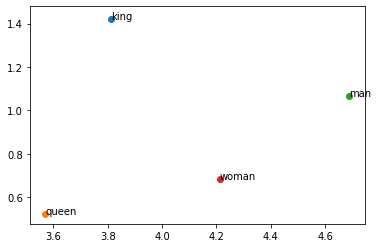

In [0]:
# Visualize
plot_embeddings(words=["king", "queen", "man", "woman"], 
                embeddings=glove, 
                pca_results=pca_results)

In [0]:
# Bias in embeddings
glove.most_similar(positive=['woman', 'doctor'], negative=['man'], topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('nurse', 0.7735227346420288),
 ('physician', 0.7189429998397827),
 ('doctors', 0.6824328303337097),
 ('patient', 0.6750682592391968),
 ('dentist', 0.6726033687591553)]

# Data

## Load data

We will download the [AG News dataset](http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html), which consists of 120000 text samples from 4 unique classes ('Business', 'Sci/Tech', 'Sports', 'World')

In [0]:
import pandas as pd
import re
import urllib

In [0]:
DATA_FILE = 'news.csv'
INPUT_FEATURE = 'title'
OUTPUT_FEATURE = 'category'

In [0]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/practicalAI/practicalAI/master/data/news.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

In [0]:
# Load data
df = pd.read_csv(DATA_FILE, header=0)
X = df[INPUT_FEATURE].values
y = df[OUTPUT_FEATURE].values
df.head(5)

,title,category
0,Wall St. Bears Claw Back Into the Black (Reuters),Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,Business
4,"Oil prices soar to all-time record, posing new...",Business


## Split data

In [0]:
import collections
from sklearn.model_selection import train_test_split

In [0]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

In [0]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (86700,), y_train: (86700,)
X_val: (15300,), y_val: (15300,)
X_test: (18000,), y_test: (18000,)
Sample point: Deep Impact Space Probe Aims to Slam Into Comet (Reuters) → Sci/Tech
Classes: {'Business': 30000, 'Sci/Tech': 30000, 'Sports': 30000, 'World': 30000}


## Tokenizer

Unlike the previous notebook, we will be processing our text at a word-level (as opposed to character-level).

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [0]:
FILTERS = "!\"'#$%&()*+,-./:;<=>?@[\\]^_`{|}~"
LOWER = True
CHAR_LEVEL = False

In [0]:
def decode(indices, tokenizer):
    """Decode a list of indices into string."""
    return " ".join([tokenizer.index_word[index] for index in indices])

In [0]:
# Input vectorizer
X_tokenizer = Tokenizer(
    filters=FILTERS, lower=LOWER, char_level=CHAR_LEVEL, oov_token='<UNK>')

In [0]:
# Fit only on train data
X_tokenizer.fit_on_texts(X_train)
vocab_size = len(X_tokenizer.word_index) + 1
print (f"# tokens: {vocab_size}")

# tokens: 29795


In [0]:
# Convert text to sequence of tokens
original_text = X_train[0]
X_train = np.array(X_tokenizer.texts_to_sequences(X_train))
X_val = np.array(X_tokenizer.texts_to_sequences(X_val))
X_test = np.array(X_tokenizer.texts_to_sequences(X_test))
preprocessed_text = decode(X_train[0], X_tokenizer)
print (f"{original_text} \n\t→ {preprocessed_text} \n\t→ {X_train[0]}")

Deep Impact Space Probe Aims to Slam Into Comet (Reuters) 
	→ deep impact space probe aims to slam into comet reuters 
	→ [2072, 1544, 92, 197, 563, 2, 2194, 69, 4804, 16]


## LabelEncoder

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
# Output vectorizer
y_tokenizer = LabelEncoder()

In [0]:
# Fit on train data
y_tokenizer = y_tokenizer.fit(y_train)
classes = list(y_tokenizer.classes_)
print (f"classes: {classes}")

classes: ['Business', 'Sci/Tech', 'Sports', 'World']


In [0]:
# Convert labels to tokens
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: 1


In [0]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [21675 21675 21675 21675],
class weights: {0: 4.61361014994233e-05, 1: 4.61361014994233e-05, 2: 4.61361014994233e-05, 3: 4.61361014994233e-05}


## Generators

In [0]:
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence

In [0]:
BATCH_SIZE = 64
FILTER_SIZES = [2, 3, 4]

In [0]:
class DataGenerator(Sequence):
    """Custom data loader."""
    def __init__(self, X, y, batch_size, max_filter_size, shuffle=False):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.max_filter_size = max_filter_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """# of batches."""
        return math.ceil(len(self.X) / self.batch_size)

    def __str__(self):
        return (f"<DataGenerator(" \
                f"batch_size={self.batch_size}, " \
                f"batches={len(self)}, " \
                f"shuffle={self.shuffle})>")

    def __getitem__(self, index):
        """Generate a batch."""
        # Gather indices for this batch
        batch_indices = self.epoch_indices[
            index * self.batch_size:(index+1)*self.batch_size]

        # Generate batch data
        X, y = self.create_batch(batch_indices=batch_indices)

        return X, y

    def on_epoch_end(self):
        """Create indices after each epoch."""
        self.epoch_indices = np.arange(len(self.X))
        if self.shuffle == True:
            np.random.shuffle(self.epoch_indices)

    def create_batch(self, batch_indices):
        """Generate batch from indices."""
        # Get batch data
        X = self.X[batch_indices]
        y = self.y[batch_indices]

        # Pad batch
        max_seq_len = max(self.max_filter_size, max([len(x) for x in X]))
        X = pad_sequences(X, padding="post", maxlen=max_seq_len)

        return X, y

In [0]:
# Dataset generator
training_generator = DataGenerator(X=X_train,
                                   y=y_train,
                                   batch_size=BATCH_SIZE,
                                   max_filter_size=max(FILTER_SIZES),
                                   shuffle=SHUFFLE)
validation_generator = DataGenerator(X=X_val,
                                     y=y_val,
                                     batch_size=BATCH_SIZE,
                                     max_filter_size=max(FILTER_SIZES),
                                     shuffle=False)
testing_generator = DataGenerator(X=X_test,
                                  y=y_test,
                                  batch_size=BATCH_SIZE,
                                  max_filter_size=max(FILTER_SIZES),
                                  shuffle=False)

In [0]:
print (f"training_generator: {training_generator}")
print (f"validation_generator: {validation_generator}")
print (f"testing_generator: {testing_generator}")

training_generator: <DataGenerator(batch_size=64, batches=1355, shuffle=True)>
validation_generator: <DataGenerator(batch_size=64, batches=240, shuffle=False)>
testing_generator: <DataGenerator(batch_size=64, batches=282, shuffle=False)>


In [0]:
# Sample iteration through a generator
print (f"num test batches: {len(testing_generator)}")
for i, batch in enumerate(testing_generator):
    if i >= 10: break
    print (f"batch {i} | X: {batch[0].shape}, y: {batch[1].shape}")

num test batches: 282
batch 0 | X: (64, 15), y: (64,)
batch 1 | X: (64, 12), y: (64,)
batch 2 | X: (64, 16), y: (64,)
batch 3 | X: (64, 17), y: (64,)
batch 4 | X: (64, 20), y: (64,)
batch 5 | X: (64, 19), y: (64,)
batch 6 | X: (64, 17), y: (64,)
batch 7 | X: (64, 18), y: (64,)
batch 8 | X: (64, 13), y: (64,)
batch 9 | X: (64, 18), y: (64,)


# Embeddings

We can embed our inputs using the [embedding layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embeddingg).

In [0]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Input

In [0]:
# Inputs
x = Input(shape=(10)) # (batch_size, max_seq_len)

In [0]:
# Embeddings
embedding = Embedding(input_dim=10, # vocab size
                      output_dim=100) # embedding dim)

In [0]:
# Embed input
embedding(x).shape

TensorShape([None, 10, 100])

Each id (token) in the input has been embedded using the embeddings. In the model below, we'll see how to preset our embeddings with our GloVe embeddings and how to choose whether to freeze (don't change during training) those embeddings or not. 

# Modeling

## Model

Let's visualize the model's forward pass.

1. We'll first tokenize our inputs (`batch_size`, `max_seq_len`).
2. Then we'll embed our tokenized inputs (`batch_size`, `max_seq_len`, `embedding_dim`).
3. We'll apply convolution via filters (`filter_size`, `vocab_size`, `num_filters`) followed by batch normalization. Our filters act as character level n-gram detecors. We have three different filter sizes (2, 3 and 4) and they will act as bi-gram, tri-gram and 4-gram feature extractors, respectivelyy. 
4. We'll apply 1D global max pooling which will extract the most relevant information from the feature maps for making the decision.
5. We feed the pool outputs to a fully-connected (FC) layer (with dropout).
6. We use one more FC layer with softmax to derive class probabilities. 

<div align="left">
<img src="https://raw.githubusercontent.com/practicalAI/images/master/basic_ml/11_Embeddings/forward_pass.png" width="1000">
</div>

The `FILTER_SIZES` are [2, 3, 4] which effectively act as bi-gram, tri-gram and 4th-gram feature extractors when applied to our text.

In [0]:
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalMaxPool1D
from tensorflow.keras.layers import Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [0]:
class CNN(Model):
    def __init__(self, vocab_size, embedding_dim, filter_sizes, num_filters,
                 hidden_dim, dropout_p, num_classes, freeze_embeddings=False):
        super(CNN, self).__init__(name="cnn")

        # Embeddings
        self.embedding = Embedding(input_dim=vocab_size,
                                   output_dim=embedding_dim,
                                   trainable=not freeze_embeddings)
        # Convolutional filters
        self.convs = []
        self.pools = []
        for filter_size in filter_sizes:
            conv = Conv1D(filters=num_filters, kernel_size=filter_size, 
                          padding='same', activation='relu')
            pool = GlobalMaxPool1D(data_format='channels_last')
            self.convs.append(conv)
            self.pools.append(pool)

        # Concatenation
        self.concat = Concatenate(axis=1)

        # FC layers
        self.fc1 = Dense(units=hidden_dim, activation='relu')
        self.dropout = Dropout(rate=dropout_p)
        self.fc2 = Dense(units=num_classes, activation='softmax')

    def call(self, x_in, training=False):
        """Forward pass."""

        # Embed
        x_emb = self.embedding(x_in)

        # Convolutions
        convs = []
        for i in range(len(self.convs)):
            z = self.convs[i](x_emb)
            z = self.pools[i](z)
            convs.append(z)

        # Concatenate
        z_cat = self.concat(convs)

        # FC
        z = self.fc1(z_cat)
        if training:
            z = self.dropout(z, training=training)
        y_pred = self.fc2(z)

        return y_pred

    def summary(self, input_shape):
        x_in = Input(shape=input_shape, name='X')
        summary = Model(inputs=x_in, outputs=self.call(x_in), name=self.name)
        return plot_model(summary, show_shapes=True) # forward pass

## GloVe embeddings

In [0]:
def load_glove_embeddings(embeddings_file):
    """Load embeddings from a file."""
    embeddings = {}
    with open(embeddings_file, "r") as fp:
        for index, line in enumerate(fp):
            values = line.split()
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings[word] = embedding
    return embeddings

In [0]:
def make_embeddings_matrix(embeddings, word_index, embedding_dim):
    """Create embeddings matrix to use in Embedding layer."""
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [0]:
# Create embeddings
embeddings_file = 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
glove_embeddings = load_glove_embeddings(embeddings_file=embeddings_file)
embedding_matrix = make_embeddings_matrix(embeddings=glove_embeddings, 
                                          word_index=X_tokenizer.word_index, 
                                          embedding_dim=EMBEDDING_DIM)
print (f"<Embeddings(words={embedding_matrix.shape[0]}, dim={embedding_matrix.shape[1]})>")

<Embeddings(words=29795, dim=100)>


## Experiments

Once you have chosen your embeddings, you can choose to freeze them or continue to train them using the supervised data (this could lead to overfitting). In this example, we will do three experiments: 
* frozen GloVe embeddings
* fine-tuned (unfrozen) GloVe embeddings
* randomly initialized embeddings

In [0]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
%load_ext tensorboard

In [0]:
EMBEDDING_DIM = 100
NUM_FILTERS = 50
HIDDEN_DIM = 100
DROPOUT_P = 0.1
LEARNING_RATE = 1e-3
EARLY_STOPPING_CRITERIA = 3
NUM_EPOCHS = 10

### GloVe embeddings (frozen)

In [0]:
FREEZE_EMBEDDINGS = True

In [0]:
# Initialize model
glove_frozen_model = CNN(vocab_size=vocab_size,
                         embedding_dim=EMBEDDING_DIM,
                         filter_sizes=FILTER_SIZES,
                         num_filters=NUM_FILTERS,
                         hidden_dim=HIDDEN_DIM,
                         dropout_p=DROPOUT_P,
                         num_classes=len(classes),
                         freeze_embeddings=FREEZE_EMBEDDINGS)

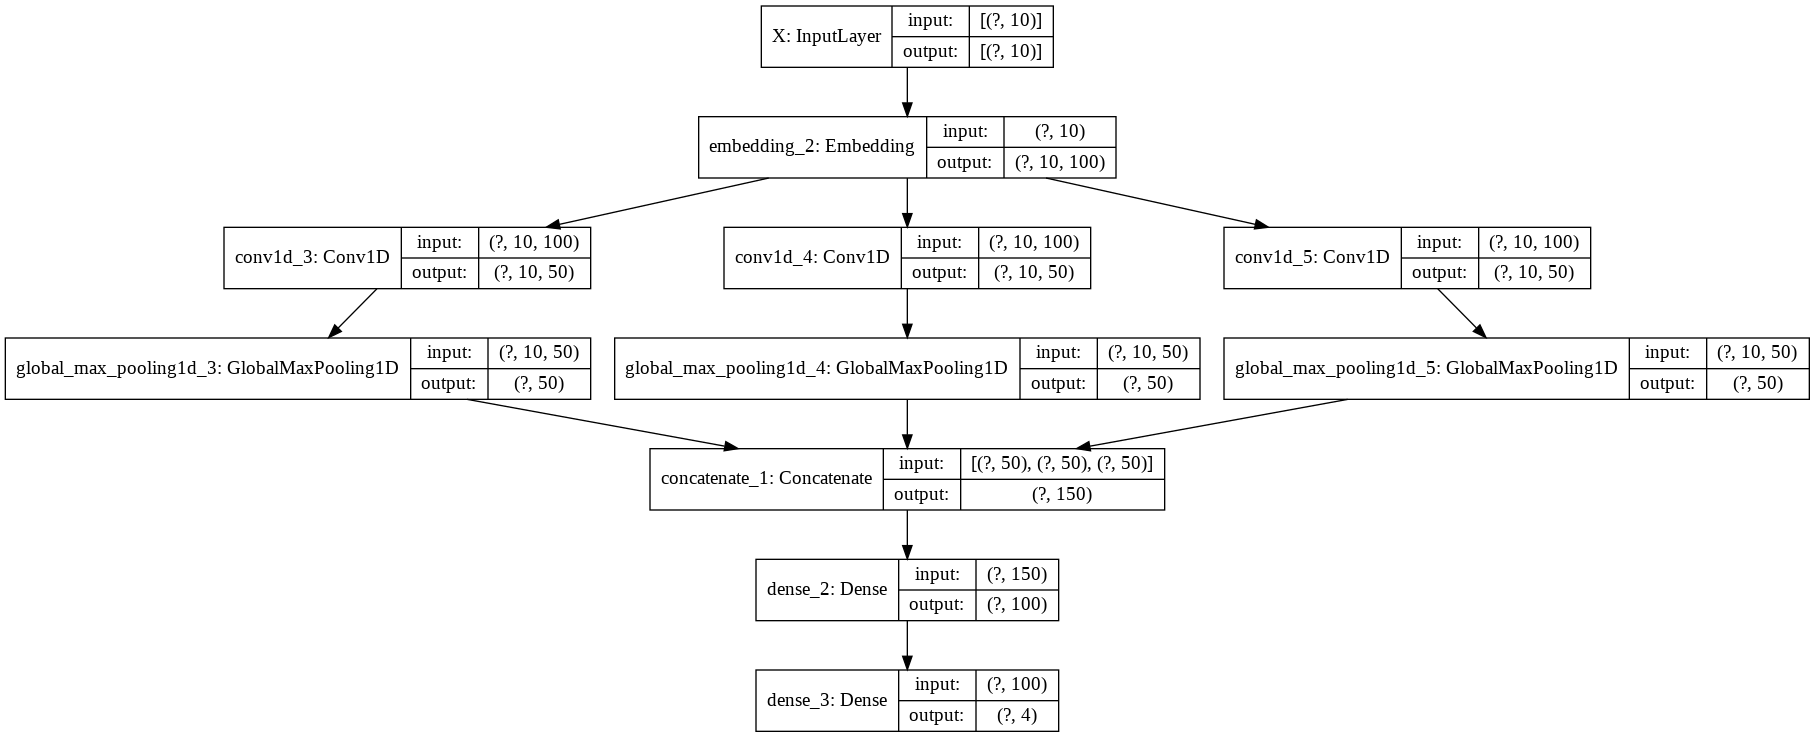

In [0]:
# Summary
vocab_size = len(X_tokenizer.word_index) + 1 # +1 for padding token 
glove_frozen_model.summary(input_shape=(10,))

In [0]:
# Set embeddings
glove_frozen_model.layers[0].set_weights([embedding_matrix])

In [0]:
# Compile
glove_frozen_model.compile(optimizer=Adam(lr=LEARNING_RATE),
                           loss=SparseCategoricalCrossentropy(),
                           metrics=[SparseCategoricalAccuracy()])

In [0]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_CRITERIA, verbose=1, mode='min'),
             ReduceLROnPlateau(patience=1, factor=0.1, verbose=0),
             TensorBoard(log_dir='tensorboard/glove_frozen', histogram_freq=1, update_freq='epoch')]

In [0]:
# Training
training_history = glove_frozen_model.fit(x=training_generator,
                                          epochs=NUM_EPOCHS,
                                          validation_data=validation_generator,
                                          callbacks=callbacks,
                                          shuffle=False,
                                          class_weight=class_weights,
                                          verbose=1)

  ...
    to  
  ['...']
Train for 1355 steps, validate for 240 steps
Epoch 1/10
1355/1355 [==============================] - 10s 7ms/step - loss: 2.2656e-05 - sparse_categorical_accuracy: 0.8240 - val_loss: 1.9310e-05 - val_sparse_categorical_accuracy: 0.8459
Epoch 2/10
1355/1355 [==============================] - 9s 7ms/step - loss: 1.7222e-05 - sparse_categorical_accuracy: 0.8676 - val_loss: 1.8492e-05 - val_sparse_categorical_accuracy: 0.8529
Epoch 3/10
1355/1355 [==============================] - 9s 7ms/step - loss: 1.4457e-05 - sparse_categorical_accuracy: 0.8893 - val_loss: 1.7581e-05 - val_sparse_categorical_accuracy: 0.8626
Epoch 4/10
1355/1355 [==============================] - 9s 7ms/step - loss: 1.3921e-05 - sparse_categorical_accuracy: 0.8934 - val_loss: 1.7515e-05 - val_sparse_categorical_accuracy: 0.8641
Epoch 5/10
1355/1355 [==============================] - 9s 7ms/step - loss: 1.3888e-05 - sparse_categorical_accuracy: 0.8944 - val_loss: 1.7512e-05 - val_sparse_categori

In [0]:
# Evaluation
testing_history = glove_frozen_model.evaluate(x=testing_generator, verbose=1)

  ...
    to  
  ['...']
282/282 [==============================] - 1s 3ms/step - loss: 0.3778 - sparse_categorical_accuracy: 0.8680


### Fine-tuned GloVe embeddings (unfrozen)

In [0]:
# Arguments
FREEZE_EMBEDDINGS = False

In [0]:
# Initialize model
glove_finetuned_model = CNN(vocab_size=vocab_size,
                            embedding_dim=EMBEDDING_DIM,
                            filter_sizes=FILTER_SIZES,
                            num_filters=NUM_FILTERS,
                            hidden_dim=HIDDEN_DIM,
                            dropout_p=DROPOUT_P,
                            num_classes=len(classes),
                            freeze_embeddings=FREEZE_EMBEDDINGS)

In [0]:
# Set embeddings
glove_finetuned_model.layers[0].set_weights([embedding_matrix])

In [0]:
# Compile
glove_finetuned_model.compile(optimizer=Adam(lr=LEARNING_RATE),
                              loss=SparseCategoricalCrossentropy(),
                              metrics=[SparseCategoricalAccuracy()])

In [0]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_CRITERIA, verbose=1, mode='min'),
             ReduceLROnPlateau(patience=1, factor=0.1, verbose=0),
             TensorBoard(log_dir='tensorboard/glove_finetuned', histogram_freq=1, update_freq='epoch')]

In [0]:
# Training
training_history = glove_finetuned_model.fit(x=training_generator,
                                             epochs=NUM_EPOCHS,
                                             validation_data=validation_generator,
                                             callbacks=callbacks,
                                             shuffle=False,
                                             class_weight=class_weights,
                                             verbose=1) 

  ...
    to  
  ['...']
Train for 1355 steps, validate for 240 steps
Epoch 1/10
1355/1355 [==============================] - 44s 33ms/step - loss: 2.2739e-05 - sparse_categorical_accuracy: 0.8217 - val_loss: 1.9101e-05 - val_sparse_categorical_accuracy: 0.8495
Epoch 2/10
1355/1355 [==============================] - 43s 32ms/step - loss: 1.6801e-05 - sparse_categorical_accuracy: 0.8720 - val_loss: 1.8073e-05 - val_sparse_categorical_accuracy: 0.8577
Epoch 3/10
1355/1355 [==============================] - 44s 32ms/step - loss: 1.3731e-05 - sparse_categorical_accuracy: 0.8961 - val_loss: 1.7467e-05 - val_sparse_categorical_accuracy: 0.8649
Epoch 4/10
1355/1355 [==============================] - 43s 32ms/step - loss: 1.3238e-05 - sparse_categorical_accuracy: 0.9002 - val_loss: 1.7423e-05 - val_sparse_categorical_accuracy: 0.8654
Epoch 5/10
1355/1355 [==============================] - 43s 32ms/step - loss: 1.3159e-05 - sparse_categorical_accuracy: 0.9008 - val_loss: 1.7422e-05 - val_sparse

In [0]:
# Evaluation
testing_history = glove_finetuned_model.evaluate(x=testing_generator, verbose=1)

  ...
    to  
  ['...']
282/282 [==============================] - 1s 3ms/step - loss: 0.3717 - sparse_categorical_accuracy: 0.8703


### Randomly initialized embeddings

In [0]:
# Arguments
FREEZE_EMBEDDINGS = False

In [0]:
random_initialized_model = CNN(vocab_size=vocab_size,
                               embedding_dim=EMBEDDING_DIM,
                               filter_sizes=FILTER_SIZES,
                               num_filters=NUM_FILTERS,
                               hidden_dim=HIDDEN_DIM,
                               dropout_p=DROPOUT_P,
                               num_classes=len(classes),
                               freeze_embeddings=FREEZE_EMBEDDINGS)

In [0]:
# Compile
random_initialized_model.compile(optimizer=Adam(lr=LEARNING_RATE),
                                 loss=SparseCategoricalCrossentropy(),
                                 metrics=[SparseCategoricalAccuracy()])

In [0]:
# Callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=EARLY_STOPPING_CRITERIA, verbose=1, mode='min'),
             ReduceLROnPlateau(patience=1, factor=0.1, verbose=0),
             TensorBoard(log_dir='tensorboard/randomly_initialized', histogram_freq=1, update_freq='epoch')]

In [0]:
# Training
training_history = random_initialized_model.fit(x=training_generator,
                                                epochs=NUM_EPOCHS,
                                                validation_data=validation_generator,
                                                callbacks=callbacks,
                                                shuffle=False,
                                                class_weight=class_weights,
                                                verbose=1)

  ...
    to  
  ['...']
Train for 1355 steps, validate for 240 steps
Epoch 1/10
1355/1355 [==============================] - 43s 32ms/step - loss: 4.2417e-05 - sparse_categorical_accuracy: 0.6110 - val_loss: 2.1747e-05 - val_sparse_categorical_accuracy: 0.8343
Epoch 2/10
1355/1355 [==============================] - 43s 32ms/step - loss: 1.7141e-05 - sparse_categorical_accuracy: 0.8733 - val_loss: 1.8753e-05 - val_sparse_categorical_accuracy: 0.8605
Epoch 3/10
1355/1355 [==============================] - 44s 32ms/step - loss: 1.0202e-05 - sparse_categorical_accuracy: 0.9306 - val_loss: 1.8146e-05 - val_sparse_categorical_accuracy: 0.8677
Epoch 4/10
1355/1355 [==============================] - 43s 32ms/step - loss: 9.1638e-06 - sparse_categorical_accuracy: 0.9384 - val_loss: 1.8099e-05 - val_sparse_categorical_accuracy: 0.8675
Epoch 5/10
1355/1355 [==============================] - 43s 32ms/step - loss: 9.0433e-06 - sparse_categorical_accuracy: 0.9393 - val_loss: 1.8094e-05 - val_sparse

In [0]:
# Evaluation
testing_history = random_initialized_model.evaluate(x=testing_generator, verbose=1)

  ...
    to  
  ['...']
282/282 [==============================] - 1s 3ms/step - loss: 0.4001 - sparse_categorical_accuracy: 0.8667


In [0]:
%tensorboard --logdir tensorboard

## Evaluation

Looks like fine-tuned glove embeddings had the best test performance (based on validation loss) so let's do proper evaluation and inference with that strategy.

In [0]:
model = glove_finetuned_model

In [0]:
import io
import itertools
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """Plot a confusion matrix using ground truth and predictions."""
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #  Figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Axis
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    ax.set_xticklabels([''] + classes)
    ax.set_yticklabels([''] + classes)
    ax.xaxis.set_label_position('bottom') 
    ax.xaxis.tick_bottom()

    # Values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:d} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Display
    plt.show()

In [0]:
def get_performance(y_true, y_pred, classes):
    """Per-class performance metrics. """
    performance = {'overall': {}, 'class': {}}
    y_pred = np.argmax(y_pred, axis=1)
    metrics = precision_recall_fscore_support(y_true, y_pred)

    # Overall performance
    performance['overall']['precision'] = np.mean(metrics[0])
    performance['overall']['recall'] = np.mean(metrics[1])
    performance['overall']['f1'] = np.mean(metrics[2])
    performance['overall']['num_samples'] = np.float64(np.sum(metrics[3]))

    # Per-class performance
    for i in range(len(classes)):
        performance['class'][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i])
        }

    return performance

In [0]:
# Evaluation
test_history = model.evaluate(x=testing_generator, verbose=1)
y_pred = model.predict(x=testing_generator, verbose=1)
print (f"test history: {test_history}")

  ...
    to  
  ['...']
282/282 [==============================] - 1s 2ms/step
test history: [0.3716698927236787, 0.87027776]


In [0]:
# Class performance
performance = get_performance(y_true=y_test, y_pred=y_pred, classes=classes)
print (json.dumps(performance, indent=4))

{
    "overall": {
        "precision": 0.8702436548002014,
        "recall": 0.8702777777777778,
        "f1": 0.8699649819796179,
        "num_samples": 18000.0
    },
    "class": {
        "Business": {
            "precision": 0.8464,
            "recall": 0.8228888888888889,
            "f1": 0.8344788732394366,
            "num_samples": 4500.0
        },
        "Sci/Tech": {
            "precision": 0.8395815170008718,
            "recall": 0.856,
            "f1": 0.8477112676056339,
            "num_samples": 4500.0
        },
        "Sports": {
            "precision": 0.8958509737510584,
            "recall": 0.9404444444444444,
            "f1": 0.9176062445793581,
            "num_samples": 4500.0
        },
        "World": {
            "precision": 0.8991421284488755,
            "recall": 0.8617777777777778,
            "f1": 0.880063542494043,
            "num_samples": 4500.0
        }
    }
}


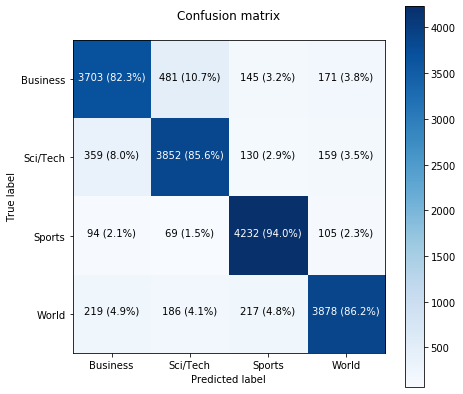

              precision    recall  f1-score   support

           0       0.85      0.82      0.83      4500
           1       0.84      0.86      0.85      4500
           2       0.90      0.94      0.92      4500
           3       0.90      0.86      0.88      4500

    accuracy                           0.87     18000
   macro avg       0.87      0.87      0.87     18000
weighted avg       0.87      0.87      0.87     18000



In [0]:
# Confusion matrix
plt.rcParams["figure.figsize"] = (7,7)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred, classes=classes)
print (classification_report(y_test, y_pred))

## Inference

In [0]:
import collections

In [0]:
def get_probability_distributions(probabilities, classes):
    """Produce probability distributions with labels."""
    probability_distributions = []
    for i, y_prob in enumerate(probabilities):
        probability_distribution = {}
        for j, prob in enumerate(y_prob):
            probability_distribution[classes[j]] = np.float64(prob)
        probability_distribution = collections.OrderedDict(
            sorted(probability_distribution.items(), key=lambda kv: kv[1], reverse=True))
        probability_distributions.append(probability_distribution)
    return probability_distributions

In [0]:
# Inputs
texts = ["This weekend the greatest tennis players will fight for the championship."]
num_samples = len(texts)
X_infer = np.array(X_tokenizer.texts_to_sequences(texts))
print (f"{texts[0]} \n\t→ {decode(X_infer[0], X_tokenizer)} \n\t→ {X_infer[0]}")
print (f"len(X_infer[0]): {len(X_infer[0])} words")
y_filler = np.array([0]*num_samples)

This weekend the greatest tennis players will fight for the championship. 
	→ this weekend the greatest tennis players will fight for the championship 
	→ [ 268 2165   10 6842  869  376   61  241    5   10 1516]
len(X_infer[0]): 11 words


In [0]:
# Inference data generator
inference_generator = DataGenerator(X=X_infer,
                                    y=y_filler,
                                    batch_size=BATCH_SIZE,
                                    max_filter_size=max(FILTER_SIZES),
                                    shuffle=False)

In [0]:
# Predict
probabilities = model.predict(x=inference_generator, verbose=1)

1/1 [==============================] - 0s 26ms/step


In [0]:
# Results
probability_distributions = get_probability_distributions(probabilities=probabilities,
                                                          classes=y_tokenizer.classes_)
results = []
for index in range(num_samples):
    results.append({
        'raw_input': texts[index],
        'preprocessed_input': decode(indices=X_infer[index], tokenizer=X_tokenizer),
        'tokenized_input': str(X_infer[index]),
        'probabilities': probability_distributions[index]
                   })
print (json.dumps(results, indent=4))

[
    {
        "raw_input": "This weekend the greatest tennis players will fight for the championship.",
        "preprocessed_input": "this weekend the greatest tennis players will fight for the championship",
        "tokenized_input": "[ 268 2165   10 6842  869  376   61  241    5   10 1516]",
        "probabilities": {
            "Sports": 0.9703105092048645,
            "World": 0.028583992272615433,
            "Sci/Tech": 0.00092971051344648,
            "Business": 0.00017576973186805844
        }
    }
]


# Interpretability

Recall that each our unique filter sizes (2, 3 and 4) act as n-gram feature detectors. When these filters convolve on our embedded input (`N`, `max_seq_len`, `embedding_dim`), they produce feature maps which are shape ((`N`, `max_seq_len`, `num_filters`) for each filter size. Since we used `SAME` padding with stride=1, our feature maps have the same length as our inputs ('max_seq_len') which you can think of as what the filters extracted from each n-gram window. When we apply 1d global max-pooling we're effectively extracting the most relevant information from the feature maps. We can inspect the trained model at the pooling step to determine which n-grams were most relevant towards the prediction.

In [0]:
import seaborn as sns
from statistics import mode

We're going to copy the same model structure as before but now we'll stop just after convolution since those are the outputs we care about.

In [0]:
class ConvOutputsModels(Model):
    def __init__(self, vocab_size, embedding_dim, filter_sizes, num_filters):
        super(ConvOutputsModels, self).__init__()

        # Embeddings
        self.embedding = Embedding(input_dim=vocab_size,
                                   output_dim=embedding_dim)
        # Convolutional filters
        self.convs = []
        for filter_size in filter_sizes:
            conv = Conv1D(filters=num_filters, kernel_size=filter_size, 
                          padding='same', activation='relu')
            self.convs.append(conv)
            
    def call(self, x_in, training=False):
        """Forward pass."""

        # Embed
        x_emb = self.embedding(x_in)

        # Convolutions
        convs = []
        for i in range(len(self.convs)):
            z = self.convs[i](x_emb)
            convs.append(z)

        return convs

    def summary(self, input_shape):
        x_in = Input(shape=input_shape, name='X')
        summary = Model(inputs=x_in, outputs=self.call(x_in), name=self.name)
        return plot_model(summary, show_shapes=True) # forward pass

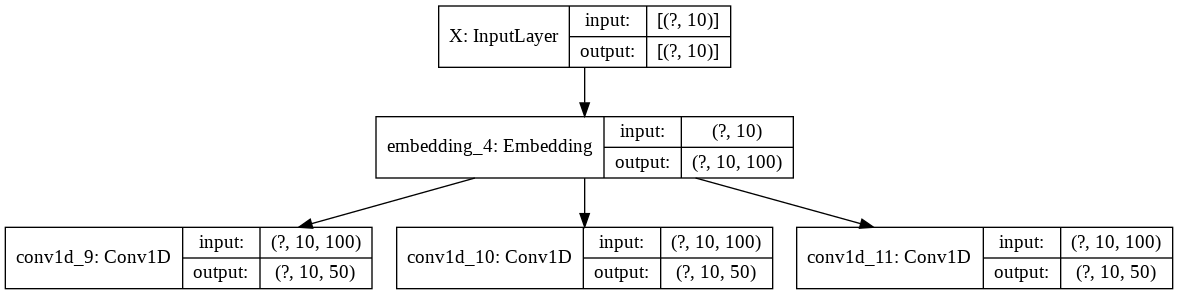

In [0]:
# Initialize model
conv_layer_outputs_model = ConvOutputsModels(vocab_size=vocab_size, 
                                             embedding_dim=EMBEDDING_DIM, 
                                             filter_sizes=FILTER_SIZES, 
                                             num_filters=NUM_FILTERS)
conv_layer_outputs_model.summary(input_shape=(10,))

Since we already trained our model, we'll transfer those weights to our new model.

In [0]:
# Model's layers
conv_layer_outputs_model.layers

In [0]:
# Set embeddings weights
conv_layer_outputs_model.layers[0].set_weights(model.layers[0].get_weights())

# Set conv weights
conv_layer_start_num = 1
for layer_num in range(conv_layer_start_num, conv_layer_start_num + len(FILTER_SIZES)):
    conv_layer_outputs_model.layers[layer_num].set_weights(model.layers[layer_num].get_weights())

In [0]:
# Forward pass
conv_outputs = conv_layer_outputs_model.predict(x=inference_generator, verbose=1)
print (len(conv_outputs)) # each filter_size has feature maps
print (conv_outputs[0].shape)

1/1 [==============================] - 0s 42ms/step
3
(1, 11, 50)


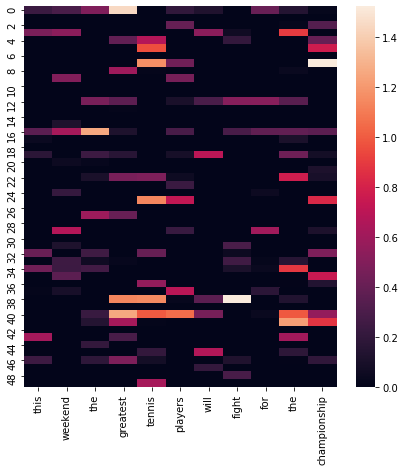

In [0]:
# Visualize bi-gram filters
tokens = decode(X_infer[0], X_tokenizer).split()
sns.heatmap(conv_outputs[0][0].T, xticklabels=tokens)

1D global max-pooling would extract the highest value from each of our num_filters for each filter size. We could also follow this same approach to figure out which n-gram is most relevant but notice in the heatmap above that many filters don't have much variance. To mitigate this, this [paper](https://www.aclweb.org/anthology/W18-5408/) uses threshold values to determine which filters to use for interpretability. 

To keep things simple and since the feature map values are fairly normalized, we'll just take the sum of values for each token index and use the index that has the max value as th emost influential index.

In [0]:
sample_index = 0
print (f"Preprocessed text:\n{decode(indices=X_infer[sample_index], tokenizer=X_tokenizer)}")
print ("\nMost important n-grams:")
# Process conv outputs for each unique filter size
for i, filter_size in enumerate(FILTER_SIZES):
    
    # Identify most important n-gram
    filter_sums = np.sum(conv_outputs[i][sample_index], axis=1)
    
    # Get corresponding text
    start = np.argmax(filter_sums)
    gram = " ".join([X_tokenizer.index_word[index] for index in X_infer[sample_index][start:start+filter_size]])
    print (f"[{filter_size}-gram]: {gram}")

Preprocessed text:
this weekend the greatest tennis players will fight for the championship

Most important n-grams:
[2-gram]: tennis players
[3-gram]: players will fight
[4-gram]: players will fight for


---
Share and discover ML projects at <a href="https://madewithml.com/">Made With ML</a>.

<div align="left">
<a class="ai-header-badge" target="_blank" href="https://github.com/practicalAI/practicalAI"><img src="https://img.shields.io/github/stars/practicalAI/practicalAI.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
</div>
             